# Kalman Filter
> Implementation of Kalman filters using pytorch and parameter optimizations with gradient descend

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp kalman.filter

In [ ]:
#| export
from fastcore.test import *
from fastcore.basics import patch
from meteo_imp.utils import *
from meteo_imp.data_preparation import MeteoDataTest
import pykalman
from typing import *

import numpy as np
import pandas as pd
import torch
from torch import Tensor
from torch.distributions import MultivariateNormal

## Introduction

## Utils

In [ ]:
#| exporti
def array1d(X):
    """Returns at least 1-d array with data from X"""
    return torch.atleast_1d(torch.as_tensor(X))

def array2d(X):
    """Returns at least 2-d array with data from X"""
    return torch.atleast_2d(torch.as_tensor(X))


In [ ]:
#| export
def _determine_dimensionality(variables, default):
    """Derive the dimensionality of the state space

    Parameters
    ----------
    variables : list of ({None, array}, conversion function, index)
        variables, functions to convert them to arrays, and indices in those
        arrays to derive dimensionality from.
        
    Returns
    -------
    dim : int
        dimensionality of state space as derived from variables or default.
    """
    # gather possible values based on the variables
    candidates = []
    for (v, converter, idx) in variables:
        if v is not None:
            v = converter(v)
            candidates.append(v.shape[idx])
    
     # also use the manually specified default
    if default is not None:
        candidates.append(default)
    
    # ensure consistency of all derived values
    if len(candidates) == 0:
        return 1
    else:
        if not torch.all(torch.tensor(candidates) == candidates[0]):
            raise ValueError(
                "The shape of all " +
                "parameters is not consistent.  " +
                "Please re-check their values."
            )
        return candidates[0]


def _last_dims(X: Tensor, t: int, ndims: int=2):
    """Extract the final dimensions of `X`

    Extract the final `ndim` dimensions at index `t` if `X` has >= `ndim` + 1
    dimensions, otherwise return `X`.

    Parameters
    ----------
    X : Tensor with at least dimension `ndims`
    t : int
        index to use for the `ndims` + 1th dimension
    ndims : int, optional
        number of dimensions in the array desired

    Returns
    -------
    Y : array with dimension `ndims`
        the final `ndims` dimensions indexed by `t`
    """
    if len(X.shape) == ndims + 1:
        return X[t]
    elif len(X.shape) == ndims:
        return X
    else:
        raise ValueError(("X only has %d dimensions when %d" +
                " or more are required") % (len(X.shape), ndims))

In [ ]:
#| export
def _stack_detach(l: Collection[Tensor]):
    return torch.stack(list(map(lambda x: x.detach(), l)))

### Positive Definite Constraint

transform any matrix $A$ into a positive definite matrix ($PD$) using the following formula

$PD = A A^T + aI$

where $AA^T$ ensures that A is positive semi-definite and adding a small positive number of the diagonal $aI$ ensures that is definite 

for details see https://stackoverflow.com/a/58192215/8555045

add also inverse transformation using cholesky decomposition


API inspired by gpytorch constraints

In [ ]:
#| export
def is_pos_semidef(cov):
    return torch.distributions.constraints.positive_semidefinite.check(cov).item()

In [ ]:
#| export
def check_is_pos_semidef(cov):
    if not is_pos_semidef(cov):
        raise ValueError(f"Not positive semi definite {cov}")

In [ ]:
#| export
class PosDef():
    """ Positive Definite Constraint for PyTorch parameters"""
    def __init__(self, a=1e-7):
        self.a = a
    def transform(self,
                  raw # square matrix that will be 
                 ):
        "transform any square matrix into a positive definite one"
        semi_pos = raw @ raw.T
        check_is_pos_semidef(semi_pos)
        return semi_pos + (self.a * torch.eye(raw.shape[0]))
    
    def inverse_transform(self,
                          value # a positive definite matrix
                         ):
        "tranform positive definite matrix into a raw matrix"
        return torch.linalg.cholesky(value)

In [ ]:
A = torch.rand(3,3)
constraint = PosDef()

posdef = constraint.transform(A)

In [ ]:
posdef

tensor([[0.3884, 0.2272, 0.7049],
        [0.2272, 0.1662, 0.3676],
        [0.7049, 0.3676, 1.4413]])

In [ ]:
test_eq(torch.distributions.constraints.positive_definite.check(posdef), True)

In [ ]:
constraint.inverse_transform(posdef)

tensor([[ 0.6232,  0.0000,  0.0000],
        [ 0.3646,  0.1825,  0.0000],
        [ 1.1310, -0.2454,  0.3193]])

In [ ]:
test_close(posdef, constraint.transform(constraint.inverse_transform(posdef)))

In [ ]:
torch.set_printoptions(precision=10)

In [ ]:
posdef

tensor([[0.3884250224, 0.2272305489, 0.7048735619],
        [0.2272305489, 0.1662481874, 0.3675557375],
        [0.7048735619, 0.3675557375, 1.4413411617]])

In [ ]:
torch.isclose(posdef, posdef.mT, atol=1e-6).all(-2).all(-1)

tensor(True)

In [ ]:
#| export
def is_symmetric(value, atol=1e-5):
    return torch.isclose(value, value.mT, atol=atol).all().item()

In [ ]:
is_symmetric(A)

False

In [ ]:
#| export
def symmetric_upto(value):
    for exp in range(-8, 1):
        if is_symmetric(value, atol=10**exp):
            return exp
    return False

In [ ]:
symmetric_upto(posdef)

-8

In [ ]:
symmetric_upto(A)

0

In [ ]:
#| export
def is_posdef(cov):
    return torch.distributions.constraints.positive_definite.check(cov).item()

In [ ]:
is_pos_semidef(posdef)

True

In [ ]:
is_posdef(A)

False

In [ ]:
is_posdef(posdef)

True

In [ ]:
torch.linalg.eigvalsh(A)

tensor([-0.6822434068,  0.2644098401,  1.5662214756])

In [ ]:
torch.linalg.eigvalsh(posdef)

tensor([0.0080209598, 0.0865252018, 1.9014680386])

check if it is pos definite using eigenvalues

In [ ]:
MultivariateNormal(torch.stack([torch.ones(3)]*2), torch.stack([posdef, torch.eye(3)]))

MultivariateNormal(loc: torch.Size([2, 3]), covariance_matrix: torch.Size([2, 3, 3]))

In [ ]:
#| export
def is_posdef2(cov):
    eigv = torch.linalg.eigvalsh(cov)
    if (eigv < 0).any():
        return False, eigv
    return True, eigv

In [ ]:
is_posdef2(posdef)

(True, tensor([0.0080209598, 0.0865252018, 1.9014680386]))

In [ ]:
is_posdef2(A)

(False, tensor([-0.6822434068,  0.2644098401,  1.5662214756]))

In [ ]:
#| export
from warnings import warn

In [ ]:
mask = torch.tril(torch.ones(3,3, dtype=torch.bool)).T
mask

tensor([[ True,  True,  True],
        [False,  True,  True],
        [False, False,  True]])

In [ ]:
A[mask]

tensor([0.3330999017, 0.4517930150, 0.2708365917, 0.3873562813, 0.0476668477,
        0.4279317856])

In [ ]:
A[mask] = torch.tril(A)[mask]

In [ ]:
#| export
def make_symmetric(value):
    "drops upper half to make matrix symmetric"
    mask = torch.tril(torch.ones_like(value, dtype=torch.bool))
    value[mask.T] = torch.tril(value)[mask]
    return value

In [ ]:
make_symmetric(A)

tensor([[0.3330999017, 0.1180299520, 0.3873562813],
        [0.1180299520, 0.9418278337, 0.6092419028],
        [0.9418278337, 0.6092419028, 0.4279317856]])

In [ ]:
is_symmetric(make_symmetric(A))

True

In [ ]:
#| export
import pandas as pd

In [ ]:
#| export
posdef_log = pd.DataFrame()

In [ ]:
#| export
def check_posdef(value, name = '', error=False):
    value = value.clone()
    is_pd_eigv, eigv = is_posdef2(value)
    is_pd_chol = torch.linalg.cholesky_ex(value).info.eq(0).item()
    is_sym = is_symmetric(value)
  
    sym = make_symmetric(value)
    is_pd_forced, _ = is_posdef2(sym)
        
    info = pd.DataFrame({
        'is_pd_eigv': is_pd_eigv,
        'is_pd_chol': is_pd_chol,
        'is_sym': is_sym,
        'sym_upto': symmetric_upto(value),
        'force_sym_posdef': is_pd_forced,
        'eigv': [eigv.detach().numpy()],
        'matrix': [value.detach().numpy()],
        'name': name
    })
    
    global posdef_log
    
    if not is_pd_eigv or not is_pd_chol:
        posdef_log = pd.concat([posdef_log, info])
        if error:
            warn("Matrix is not positive definite")
    return info

In [ ]:
check_posdef(A, 'A').dtypes

is_pd_eigv            bool
is_pd_chol            bool
is_sym                bool
sym_upto             int64
force_sym_posdef      bool
eigv                object
matrix              object
name                object
dtype: object

In [ ]:
posdef_log.dtypes

is_pd_eigv            bool
is_pd_chol            bool
is_sym                bool
sym_upto             int64
force_sym_posdef      bool
eigv                object
matrix              object
name                object
dtype: object

In [ ]:
check_posdef(posdef)

,is_pd_eigv,is_pd_chol,is_sym,sym_upto,force_sym_posdef,eigv,matrix,name
0,True,True,True,-8,True,"[0.032503378, 0.5579087, 1.9442279]","[[0.38842502, 0.22723055, 0.70487356], [0.2272...",


In [ ]:
posdef_log

,is_pd_eigv,is_pd_chol,is_sym,sym_upto,force_sym_posdef,eigv,matrix,name
0,False,False,True,-8,False,"[-0.6399728, 0.63689935, 1.7059332]","[[0.3330999, 0.11802995, 0.94182783], [0.11802...",
0,True,True,True,0,True,"[0.00802096, 0.0865252, 1.901468]","[[0.38842502, 0.22723055, 0.70487356], [0.2272...",
0,True,True,True,-8,True,"[1.0, 1.0]","[[1.0, 0.0], [0.0, 1.0]]",filter_predict
0,True,True,True,-8,True,"[1.0, 1.0]","[[1.0, 0.0], [0.0, 1.0]]",filter_predict
0,True,True,True,-8,True,"[0.5, 0.5]","[[0.5, 0.0], [0.0, 0.5]]",filter_correct
...,...,...,...,...,...,...,...,...
0,True,True,True,0,False,"[0.1385304, 0.3253069, 10.498974]","[[4.348749, 3.894421, 3.9152386], [3.894421, 3...",filter_predict
0,False,False,True,-8,False,"[-0.6399728, 0.63689935, 1.7059332]","[[0.3330999, 0.11802995, 0.94182783], [0.11802...",
0,False,False,True,-8,False,"[-0.6399728, 0.63689935, 1.7059332]","[[0.3330999, 0.11802995, 0.94182783], [0.11802...",
0,False,False,True,-8,False,"[-0.6399728, 0.63689935, 1.7059332]","[[0.3330999, 0.11802995, 0.94182783], [0.11802...",A


In [ ]:
#| export
def check_posdef4(value, error=True):
    msg = ""
    is_pd_eigv, eigv = is_posdef2(value)
    is_pd_chol = is_posdef(value)
    if not is_pd_eigv or not is_pd_chol:
        is_sym = is_symmetric(value)
        if not is_sym:
            msg += f"Not symmetric, symmetric up to 1e{symmetric_upto(value)}\n"
            msg += f"Not pos definite with eigv {eigv} \n"
        # try to make it symmetric and try again to see if it's posdef
            sym = make_symmetric(value)
            is_pd, eigv = is_posdef2(sym)
            add_msg = "forced symmetric is posdef" if is_pd else "force symmetric is not posdef"
            msg += add_msg
        
    if msg != "":
        msg += str(value)
        warn(msg)

In [ ]:
def check_posdef3(cov, error=True):
    if not is_posdef(cov):
        is_pd, eigv = is_posdef2(cov)
        if is_pd:
            print(f"actually pos definite {eigv} \n{cov}")
        else:
            msg = f"not pos definite {eigv} \n {cov}"
            if error:
                raise ValueError(msg)
            else:
                print(msg)

In [ ]:
def check_posdef2(cov):
    errors = []
    for i in range(10):
        if not is_posdef(cov):
            errors.append(i)
    if len(errors) > 0:
        print(f"at iterations {errors} not positive definite matrix. \n{cov}")

## KalmanFilter

The Kalman Filter is an algorithm designed to estimate $P(x_t | y_{0:t})$.  As all state transitions and obss are linear with Gaussian distributed noise, these distributions can be represented exactly as Gaussian distributions with mean `filt_state_means[t]` and covs `filt_state_covs[t]`.
Similarly, the Kalman Smoother is an algorithm designed to estimate $P(x_t | y_{0:T-1})$



In [ ]:
#| export
class KalmanFilter(torch.nn.Module):
    """Kalman Filter and Kalman Smoother using PyTorch"""
    def __init__(self,
            transition_matrices: Tensor=None, # [n_timesteps-1, n_dim_state, n_dim_state] or [n_dim_state,n_dim_state] 
               # Also known as $A$ 
               # state transition matrix between times t and t+1 for t in [0...n_timesteps-2]
            obs_matrices: Tensor=None, # [n_timesteps, n_dim_obs, n_dim_state] or [n_dim_obs, n_dim_state]
                # Also known as $H$
                # obs matrix for times [0...n_timesteps-1]
            transition_cov: Tensor=None, # [n_dim_state, n_dim_state] 
                 # Also known as $Q$
                 # state transition cov matrix for times [0...n_timesteps-2]
            obs_cov: Tensor=None, # [n_dim_obs, n_dim_obs]
                 # Also known as $R$
                 # obs cov matrix for times [0...n_timesteps-1]
            transition_offsets: Tensor=None, # [n_timesteps-1, n_dim_state] or [n_dim_state]
                 # Also known as $b$
                 # state offsets for times [0...n_timesteps-2]
            obs_offsets: Tensor=None, # [n_timesteps, n_dim_obs] or [n_dim_obs]
                 # Also known as $d$
            initial_state_mean: Tensor=None, # [n_dim_state]
                 # Also known as $\mu_0"$
            initial_state_cov: Tensor=None, # [n_dim_state, n_dim_state]
                 # Also known as $\Sigma_0$
            n_dim_state: int = None, # Number of dimensions for state - defaults to 1 if cannot be infered from parameters
            n_dim_obs: int = None # Number of dimensions for observations - defaults to 1 if cannot be infered from parameters
                ):
        """Initialize Kalman Filter"""
        
        super().__init__()
        
        # determine size of state space and check parameters are consistent
        n_dim_state = _determine_dimensionality(
            [(transition_matrices, array2d, -2),
             (transition_offsets, array1d, -1),
             (transition_cov, array2d, -2),
             (initial_state_mean, array1d, -1),
             (initial_state_cov, array2d, -2),
             (obs_matrices, array2d, -1)],
            n_dim_state
        )
        n_dim_obs = _determine_dimensionality(
            [(obs_matrices, array2d, -2),
             (obs_offsets, array1d, -1),
             (obs_cov, array2d, -2)],
            n_dim_obs
        )
        
        self.n_dim_obs = n_dim_obs
        self.n_dim_state = n_dim_state
        
        params = {
        # name                 value         default_value                              converter constraint train
        'transition_matrices': [transition_matrices, torch.eye(n_dim_state),            array2d, None    , True],
        'transition_offsets':  [transition_offsets,  torch.zeros(n_dim_state),          array1d, None    , True],
        'transition_cov':      [transition_cov,      torch.eye(n_dim_state),            array2d, PosDef(), True],
        'obs_matrices':        [obs_matrices,        torch.eye(n_dim_obs, n_dim_state), array2d, None    , True],
        'obs_offsets':         [obs_offsets,         torch.zeros(n_dim_obs),            array1d, None    , True],
        'obs_cov':             [obs_cov,             torch.eye(n_dim_obs),              array2d, PosDef(), True],
        'initial_state_mean':  [initial_state_mean,  torch.zeros(n_dim_state),          array1d, None    , True],
        'initial_state_cov':   [initial_state_cov,   torch.eye(n_dim_state),            array2d, PosDef(), True],
        }
        
        self._init_params(params)
        
    def _init_params(self, params):
        for name, (value, default, converter, constraint, train) in params.items():
            value = value if value is not None else default
            value = converter(value) 
            if constraint is not None:
                name, value = self._init_constraint(name, value, constraint)
            self._init_param(name, value, train)    
    
    def _init_param(self, param_name, value, train):
        self.register_parameter(param_name, torch.nn.Parameter(value, requires_grad=train))
    
    ## Constraints ----
    def _init_constraint(self, param_name, value, constraint):
        name = param_name + "_raw"
        value = constraint.inverse_transform(value)
        setattr(self, param_name + "_constraint", constraint)
        return name, value
    
    def _get_constraint(self, param_name):
        constraint = getattr(self, param_name + "_constraint")
        raw_value = getattr(self, param_name + "_raw")
        return constraint.transform(raw_value)
    
    def _set_constraint(self, param_name, value, train=True):
        constraint = getattr(self, param_name + "_constraint")
        raw_value = constraint.inverse_transform(value)
        self._init_param(param_name + "_raw", raw_value, train=True)
        

    
    ### convenience functions to get and set parameters that have a constraint
    
    @property
    def transition_cov(self):
        return self._get_constraint('transition_cov')
    
    @transition_cov.setter
    def transition_cov(self, value):
        return self._set_constraint('transition_cov', value)
    
    @property
    def obs_cov(self):
        return self._get_constraint('obs_cov')
    
    @obs_cov.setter
    def obs_cov(self, value):
        return self._set_constraint('obs_cov', value)
    
    @property
    def initial_state_cov(self):
        return self._get_constraint('initial_state_cov')
    
    @initial_state_cov.setter
    def initial_state_cov(self, value):
        return self._set_constraint('initial_state_cov', value)
    
    
    ### -----
    
    def _parse_obs(self, obs, mask=None):
        """Safely convert observations to their expected format"""
        obs = torch.atleast_2d(obs)
        if obs.shape[0] == 1 and obs.shape[1] > 1:
            obs = obs.T
        if mask is None: mask = ~torch.isnan(obs).any(axis=1)
        return obs, mask
    
    def __repr__(self):
        return f"""Kalman Filter
        N dim obs: {self.n_dim_obs}, N dim state: {self.n_dim_state}"""

In [ ]:
k = KalmanFilter()

In [ ]:
k.obs_cov

tensor([[1.0000001192]], grad_fn=<AddBackward0>)

In [ ]:
k.initial_state_cov

tensor([[1.0000001192]], grad_fn=<AddBackward0>)

In [ ]:
k.initial_state_cov = array2d(torch.tensor(3.))

In [ ]:
k.initial_state_cov

tensor([[3.]], grad_fn=<AddBackward0>)

In [ ]:
k.initial_state_cov_raw

Parameter containing:
tensor([[1.7320507765]], requires_grad=True)

In [ ]:
list(k.named_parameters())

[('transition_matrices',
  Parameter containing:
  tensor([[1.]], requires_grad=True)),
 ('transition_offsets',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('transition_cov_raw',
  Parameter containing:
  tensor([[1.]], requires_grad=True)),
 ('obs_matrices',
  Parameter containing:
  tensor([[1.]], requires_grad=True)),
 ('obs_offsets',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('obs_cov_raw',
  Parameter containing:
  tensor([[1.]], requires_grad=True)),
 ('initial_state_mean',
  Parameter containing:
  tensor([0.], requires_grad=True)),
 ('initial_state_cov_raw',
  Parameter containing:
  tensor([[1.7320507765]], requires_grad=True))]

In [ ]:
k = KalmanFilter()
# pykalman reference implementation
pyk = pykalman.KalmanFilter()

In [ ]:
X = torch.tensor([1,2,3])
nX = X.numpy()
X

tensor([1, 2, 3])

2 dimensional dobs

In [ ]:
X2 = torch.tensor([[i, 10. * i] for i in range(1,5)])
nX2 = X2.numpy()

In [ ]:
k2 = KalmanFilter(transition_matrices = torch.eye(2), obs_matrices=torch.eye(2))

pyk2 = pykalman.KalmanFilter(n_dim_obs = 2, n_dim_state=2)

In [ ]:
X2

tensor([[ 1., 10.],
        [ 2., 20.],
        [ 3., 30.],
        [ 4., 40.]])

In [ ]:
obs_mask = torch.ones_like(X2, dtype=torch.bool)
obs_mask[0, 1] = False # only one value missing
obs_mask[2, :] = False # whole row missing
# Xm X missing
X2m = X2.clone()
X2m[~obs_mask] = torch.nan
# nXm Numpy X missing
nX2m = np.ma.masked_array(X2.numpy(), mask = ~obs_mask.numpy())

In [ ]:
obs_mask

tensor([[ True, False],
        [ True,  True],
        [False, False],
        [ True,  True]])

In [ ]:
X2m

tensor([[ 1., nan],
        [ 2., 20.],
        [nan, nan],
        [ 4., 40.]])

In [ ]:
nX2m

masked_array(
  data=[[1.0, --],
        [2.0, 20.0],
        [--, --],
        [4.0, 40.0]],
  mask=[[False,  True],
        [False, False],
        [ True,  True],
        [False, False]],
  fill_value=1e+20,
  dtype=float32)

### Tester

In [ ]:
from fastcore.basics import *

In [ ]:
to_posdef = PosDef().transform

In [ ]:
class KalmanFilterTester():
    
    torch2pyk = {
        'transition_matrices': 'transition_matrices',
        'transition_offsets':  'transition_offsets',        
        'transition_cov':      'transition_covariance',        
        'obs_matrices':        'observation_matrices',
        'obs_offsets':         'observation_offsets',          
        'obs_cov':             'observation_covariance',            
        'initial_state_mean':  'initial_state_mean',        
        'initial_state_cov':   'initial_state_covariance',
    }
    
    def __init__(self,
                 n_dim_state = 3,
                n_dim_obs = 3,
                n_obs = 10,
                p_missing = .3,
                seed=42):
        store_attr(but='seed')
        reset_seed(seed)
        
        self.random_init()
    
    def random_init(self):
        self.params = {
            'transition_matrices': torch.rand(self.n_dim_state, self.n_dim_state),
            'transition_offsets':  torch.rand(self.n_dim_state),        
            'transition_cov':      to_posdef(torch.rand(self.n_dim_state, self.n_dim_state)),        
            'obs_matrices':        torch.rand(self.n_dim_obs, self.n_dim_state),
            'obs_offsets':         torch.rand(self.n_dim_obs),          
            'obs_cov':             to_posdef(torch.rand(self.n_dim_obs, self.n_dim_obs)),            
            'initial_state_mean':  torch.rand(self.n_dim_state),        
            'initial_state_cov':   to_posdef(torch.rand(self.n_dim_state, self.n_dim_state)),
        }
        self.params_pyk = {self.torch2pyk[name]: param.numpy() for name, param in self.params.items()}
        
        self.filter = KalmanFilter(**self.params)
        self.filter_pyk = pykalman.standard.KalmanFilter(**self.params_pyk)
        
        
        self.data = torch.rand(n_obs, n_dim_obs)
        self.mask = torch.rand(n_obs, n_dim_obs) > p_missing
        self.mask_torch = self.mask.all(1)
        self.data_pyk = np.ma.masked_array(self.data.numpy(), mask = self.mask.numpy()) 
    
    

In [ ]:
tst = KalmanFilterTester()

In [ ]:
test_close(tst.params.values(), tst.params_pyk.values())

### Filter

#### Filter predict

In [ ]:
#| export
from datetime import datetime
def _filter_predict(transition_matrix, transition_cov,
                    transition_offset, current_state_mean,
                    current_state_cov):
    r"""Calculate the mean and cov of :math:`P(x_{t+1} | z_{0:t})`

    Using the mean and cov of :math:`P(x_t | z_{0:t})`, calculate the
    mean and cov of :math:`P(x_{t+1} | z_{0:t})`.

    Parameters
    ----------
    transition_matrix : [n_dim_state, n_dim_state} array
        state transition matrix from time t to t+1
    transition_cov : [n_dim_state, n_dim_state] array
        cov matrix for state transition from time t to t+1
    transition_offset : [n_dim_state] array
        offset for state transition from time t to t+1
    current_state_mean: [n_dim_state] array
        mean of state at time t given obss from times
        [0...t]
    current_state_cov: [n_dim_state, n_dim_state] array
        cov of state at time t given obss from times
        [0...t]

    Returns
    -------
    pred_state_mean : [n_dim_state] array
        mean of state at time t+1 given obss from times [0...t]
    pred_state_cov : [n_dim_state, n_dim_state] array
        cov of state at time t+1 given obss from times
        [0...t]
    """
    pred_state_mean = transition_matrix @ current_state_mean + transition_offset
    pred_state_cov =  transition_matrix @ current_state_cov @ transition_matrix.T + transition_cov

    check_posdef(pred_state_cov, 'filter_predict')
    
    return (pred_state_mean, pred_state_cov)

In [ ]:
def _filter_predict2(transition_matrix, transition_covariance,
                    transition_offset, current_state_mean,
                    current_state_covariance):
    predicted_state_mean = (
        torch.matmul(transition_matrix, current_state_mean)
        + transition_offset
    )
    predicted_state_covariance = (
        torch.matmul(transition_matrix,
               torch.matmul(current_state_covariance,
                      transition_matrix.T))
        + transition_covariance
    )

    return (predicted_state_mean, predicted_state_covariance)

In [ ]:
(
    (tst.params['transition_matrices'] @ tst.params['initial_state_cov'] ) -
    torch.matmul(tst.params['transition_matrices'], tst.params['initial_state_cov'])
)

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]])

In [ ]:
(
    (tst.params['transition_matrices'] @ tst.params['initial_state_cov']  @ tst.params['transition_matrices'].T) -
    torch.matmul(tst.params['transition_matrices'], torch.matmul(tst.params['initial_state_cov'], tst.params['transition_matrices'].T))
)

tensor([[ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00],
        [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00],
        [ 0.0000000000e+00, -2.3841857910e-07,  0.0000000000e+00]])

In [ ]:
(
    (tst.params['transition_matrices'] @ tst.params['initial_state_cov']  @ tst.params['transition_matrices'].T + tst.params['transition_cov']) -
    (torch.matmul(tst.params['transition_matrices'], torch.matmul(tst.params['initial_state_cov'], tst.params['transition_matrices'].T)) + tst.params['transition_cov'])
)

tensor([[ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00],
        [ 0.0000000000e+00,  0.0000000000e+00,  0.0000000000e+00],
        [ 0.0000000000e+00, -4.7683715820e-07,  0.0000000000e+00]])

In [ ]:
trans_m = np.eye(2)
trans_cov = np.eye(2)
trans_off = np.zeros((2,2))
curr_mean = np.ones((2,1))
curr_cov = np.zeros((2,2))

In [ ]:
_filter_predict(torch.tensor(trans_m) , torch.tensor(trans_cov), torch.tensor(trans_off), torch.tensor(curr_mean), torch.tensor(curr_cov))

(tensor([[1., 1.],
         [1., 1.]], dtype=torch.float64),
 tensor([[1., 0.],
         [0., 1.]], dtype=torch.float64))

In [ ]:
test_close(
    pykalman.standard._filter_predict(trans_m , trans_cov, trans_off, curr_mean, curr_cov),
    _filter_predict(torch.tensor(trans_m) , torch.tensor(trans_cov), torch.tensor(trans_off), torch.tensor(curr_mean), torch.tensor(curr_cov)))

In [ ]:
pred_pyk = pykalman.standard._filter_predict(
   tst.params_pyk['transition_matrices'],
   tst.params_pyk['transition_covariance'],
   tst.params_pyk['transition_offsets'],
   tst.params_pyk['initial_state_mean'],
   tst.params_pyk['initial_state_covariance'],
)

In [ ]:
pred_torch = _filter_predict(
   tst.params['transition_matrices'],
   tst.params['transition_cov'],
   tst.params['transition_offsets'],
   tst.params['initial_state_mean'],
   tst.params['initial_state_cov'],

)

In [ ]:
pred_pyk[0] - pred_torch[0].numpy()

array([0., 0., 0.], dtype=float32)

In [ ]:
test_close(pred_pyk[0], pred_torch[0])

In [ ]:
pred_pyk[1] - pred_torch[1].numpy()

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 4.7683716e-07, 0.0000000e+00]], dtype=float32)

In [ ]:
test_close(pred_pyk[1], pred_torch[1])

In [ ]:
pykalman.standard._filter_predict??

Signature:
pykalman.standard._filter_predict(
    transition_matrix,
    transition_covariance,
    transition_offset,
    current_state_mean,
    current_state_covariance,
)
Source:   
def _filter_predict(transition_matrix, transition_covariance,
                    transition_offset, current_state_mean,
                    current_state_covariance):
    r"""Calculate the mean and covariance of :math:`P(x_{t+1} | z_{0:t})`

    Using the mean and covariance of :math:`P(x_t | z_{0:t})`, calculate the
    mean and covariance of :math:`P(x_{t+1} | z_{0:t})`.

    Parameters
    ----------
    transition_matrix : [n_dim_state, n_dim_state} array
        state transition matrix from time t to t+1
    transition_covariance : [n_dim_state, n_dim_state] array
        covariance matrix for state transition from time t to t+1
    transition_offset : [n_dim_state] array
        offset for state transition from time t to t+1
    current_state_mean: [n_dim_state] array
        mean of state at tim

In [ ]:
tst.params_pyk['transition_matrices'].shape

(3, 3)

In [ ]:
test_close(
   pykalman.standard._filter_predict(
       tst.params_pyk['transition_matrices'],
       tst.params_pyk['transition_covariance'],
       tst.params_pyk['transition_offsets'],
       tst.params_pyk['initial_state_mean'],
       tst.params_pyk['initial_state_covariance'],
    ),
    
    _filter_predict2(
       tst.params['transition_matrices'],
       tst.params['transition_cov'],
       tst.params['transition_offsets'],
       tst.params['initial_state_mean'],
       tst.params['initial_state_cov'],
    
    )
)

In [ ]:
test_close(
    
    _filter_predict2(
       tst.params['transition_matrices'],
       tst.params['transition_cov'],
       tst.params['transition_offsets'],
       tst.params['initial_state_mean'],
       tst.params['initial_state_cov'],
    ),
    _filter_predict(
       tst.params['transition_matrices'],
       tst.params['transition_cov'],
       tst.params['transition_offsets'],
       tst.params['initial_state_mean'],
       tst.params['initial_state_cov'],
    )
)

In [ ]:
test_close(
   pykalman.standard._filter_predict(
       tst.params_pyk['transition_matrices'],
       tst.params_pyk['transition_covariance'],
       tst.params_pyk['transition_offsets'],
       tst.params_pyk['initial_state_mean'],
       tst.params_pyk['initial_state_covariance'],
    ),
    
    _filter_predict(
       tst.params['transition_matrices'],
       tst.params['transition_cov'],
       tst.params['transition_offsets'],
       tst.params['initial_state_mean'],
       tst.params['initial_state_cov'],
    
    )
)

The issues seems is was from `check_posdef` but `torch.matmul` and `@` are correctly working as intended

#### Filter correct

In [ ]:
#| export
def _filter_correct(obs_matrix, obs_cov,
                    obs_offset, pred_state_mean,
                    pred_state_cov, obs, mask):
    r"""Correct a pred state with a Kalman Filter update

    Incorporate obs `obs` from time `t` to turn
    :math:`P(x_t | z_{0:t-1})` into :math:`P(x_t | z_{0:t})`

    Parameters
    ----------
    obs_matrix : [n_dim_obs, n_dim_state] array
        obs matrix for time t
    obs_cov : [n_dim_obs, n_dim_obs] array
        cov matrix for obs at time t
    obs_offset : [n_dim_obs] array
        offset for obs at time t
    pred_state_mean : [n_dim_state] array
        mean of state at time t given obss from times
        [0...t-1]
    pred_state_cov : [n_dim_state, n_dim_state] array
        cov of state at time t given obss from times
        [0...t-1]
    obs : [n_dim_obs] array
        obs at time t.  If `obs` is a masked array and any of
        its values are masked, the obs will be ignored.

    Returns
    -------
    kalman_gain : [n_dim_state, n_dim_obs] array
        Kalman gain matrix for time t
    corrected_state_mean : [n_dim_state] array
        mean of state at time t given obss from times
        [0...t]
    corrected_state_cov : [n_dim_state, n_dim_state] array
        cov of state at time t given obss from times
        [0...t]
    """
    if mask:
        pred_obs_mean = obs_matrix @ pred_state_mean + obs_offset
        pred_obs_cov = obs_matrix @ pred_state_cov @ obs_matrix.T + obs_cov

        kalman_gain = pred_state_cov @ obs_matrix.T @ torch.inverse(pred_obs_cov)

        corrected_state_mean = pred_state_mean + kalman_gain @ (obs - pred_obs_mean)
        corrected_state_cov = pred_state_cov - kalman_gain @ obs_matrix @ pred_state_cov
    else:
        n_dim_state = pred_state_cov.shape[0]
        n_dim_obs = obs_matrix.shape[0]
        kalman_gain = torch.zeros((n_dim_state, n_dim_obs))

        corrected_state_mean = pred_state_mean
        corrected_state_cov = pred_state_cov
        
    # check_posdef(corrected_state_cov, 'filter_correct')

    return (kalman_gain, corrected_state_mean,
            corrected_state_cov)

In [ ]:
pykalman.st

In [ ]:
args_np = {
    'obs_m': np.eye(2),
    'obs_cov': np.eye(2),
    'obs_off': np.zeros((2,1)),
    'pred_state_mean': np.ones(2),
    'pred_state_cov': np.eye(2),
    'obs': np.ones((2,1)),
}

args_torch = {k: torch.tensor(v) for k,v in args_np.items()}

In [ ]:
_filter_correct(*args_torch.values(), mask=True)

(tensor([[0.5000000000, 0.0000000000],
         [0.0000000000, 0.5000000000]], dtype=torch.float64),
 tensor([[1., 1.],
         [1., 1.]], dtype=torch.float64),
 tensor([[0.5000000000, 0.0000000000],
         [0.0000000000, 0.5000000000]], dtype=torch.float64))

In [ ]:
test_close(
    pykalman.standard._filter_correct(*args_np.values()),
    _filter_correct(*args_torch.values(), mask=True))

In [ ]:
test_close(
   pykalman.standard._filter_correct(
       tst.params_pyk['observation_matrices'],
       tst.params_pyk['observation_covariance'],
       tst.params_pyk['observation_offsets'],
       tst.params_pyk['initial_state_mean'],
       tst.params_pyk['initial_state_covariance'],
       tst.data_pyk[0]
    ),
    
    _filter_correct(
       tst.params['obs_matrices'],
       tst.params['obs_cov'],
       tst.params['obs_offsets'],
       tst.params['initial_state_mean'],
       tst.params['initial_state_cov'],
       tst.data[0],
       tst.mask_torch[0]
    )
)

AssertionError: close:
(array([[0., 0., 0.],
       [0., 0., 0.],
       [0., 0., 0.]]), array([0.7104288, 0.9464111, 0.7890298], dtype=float32), array([[1.0486015 , 0.3691155 , 0.7147802 ],
       [0.3691155 , 0.6065388 , 0.25865388],
       [0.7147802 , 0.25865388, 0.9362985 ]], dtype=float32))
(tensor([[ 0.7221071124, -1.0674444437,  0.8584222794],
        [ 0.2587594092, -1.5015394688,  2.0118002892],
        [ 0.7195330858, -0.0971457958, -0.5135169029]]), tensor([-1.2009034157, -1.2801539898,  0.1241111159]), tensor([[ 0.3472033143, -0.0683074296,  0.1338070035],
        [-0.0683076382,  0.0863308311,  0.0947744399],
        [ 0.1338068843,  0.0947745293,  0.2892767787]]))

#### Filter

In [ ]:
#| export
def _filter(transition_matrices, obs_matrices, transition_cov,
            obs_cov, transition_offsets, obs_offsets,
            initial_state_mean, initial_state_cov, obs, obs_mask):
    """Apply the Kalman Filter

    Calculate posterior distribution over hidden states given obss up
    to and including the current time step.

    Parameters
    ----------
    transition_matrices : [n_timesteps-1,n_dim_state,n_dim_state] or
    [n_dim_state,n_dim_state] array-like
        state transition matrices
    obs_matrices : [n_timesteps, n_dim_obs, n_dim_state] or [n_dim_obs, \
    n_dim_state] array-like
        obs matrix
    transition_cov : [n_timesteps-1,n_dim_state,n_dim_state] or
    [n_dim_state,n_dim_state] array-like
        state transition cov matrix
    obs_cov : [n_timesteps, n_dim_obs, n_dim_obs] or [n_dim_obs,
    n_dim_obs] array-like
        obs cov matrix
    transition_offsets : [n_timesteps-1, n_dim_state] or [n_dim_state] \
    array-like
        state offset
    obs_offsets : [n_timesteps, n_dim_obs] or [n_dim_obs] array-like
        obss for times [0...n_timesteps-1]
    initial_state_mean : [n_dim_state] array-like
        mean of initial state distribution
    initial_state_cov : [n_dim_state, n_dim_state] array-like
        cov of initial state distribution
    obss : [n_timesteps, n_dim_obs] array
        obss from times [0...n_timesteps-1].  If `obss` is a
        masked array and any of `obss[t]` is masked, then
        `obss[t]` will be treated as a missing obs.

    Returns
    -------
    pred_state_means : [n_timesteps, n_dim_state] array
        `pred_state_means[t]` = mean of hidden state at time t given
        obss from times [0...t-1]
    pred_state_covs : [n_timesteps, n_dim_state, n_dim_state] array
        `pred_state_covs[t]` = cov of hidden state at time t
        given obss from times [0...t-1]
    kalman_gains : [n_timesteps, n_dim_state] array
        `kalman_gains[t]` = Kalman gain matrix for time t
    filt_state_means : [n_timesteps, n_dim_state] array
        `filt_state_means[t]` = mean of hidden state at time t given
        obss from times [0...t]
    filt_state_covs : [n_timesteps, n_dim_state] array
        `filt_state_covs[t]` = cov of hidden state at time t
        given obss from times [0...t]
    """
    n_timesteps = obs.shape[0]
    n_dim_state = len(initial_state_mean)
    n_dim_obs = obs.shape[1]
    
    # those variables need to be lists and not Tensors,
    # otherwise pytorch tryies to compute the gradient for the whole tensor and it breaks due to the in place operations
    
    pred_state_means = [None for _ in range(n_timesteps)] # torch.zeros((n_timesteps, n_dim_state))
    pred_state_covs = [None for _ in range(n_timesteps)] # torch.zeros(
        #(n_timesteps, n_dim_state, n_dim_state)
    #)
    kalman_gains = [None for _ in range(n_timesteps)]
    filt_state_means = [None for _ in range(n_timesteps)]
    filt_state_covs = [None for _ in range(n_timesteps)]

    for t in range(n_timesteps):
        if t == 0:
            pred_state_means[t] = initial_state_mean
            pred_state_covs[t] = initial_state_cov
        else:
            transition_matrix = _last_dims(transition_matrices, t - 1)
            transition_cov = _last_dims(transition_cov, t - 1)
            transition_offset = _last_dims(transition_offsets, t - 1, ndims=1)
            pred_state_means[t], pred_state_covs[t] = (
                _filter_predict(
                    transition_matrix,
                    transition_cov,
                    transition_offset,
                    filt_state_means[t - 1],
                    filt_state_covs[t - 1]
                )
            )

        obs_matrix = _last_dims(obs_matrices, t)
        obs_cov = _last_dims(obs_cov, t)
        obs_offset = _last_dims(obs_offsets, t, ndims=1)
        (kalman_gains[t], filt_state_means[t],
         filt_state_covs[t]) = (
            _filter_correct(obs_matrix,
                obs_cov,
                obs_offset,
                pred_state_means[t],
                pred_state_covs[t],
                obs[t],
                obs_mask[t]
            )
        )

    return (pred_state_means, pred_state_covs, filt_state_means,
            filt_state_covs)

In [ ]:
args_filt_np = {
    'trans_m': np.eye(2),
    'obs_m': np.eye(2),
    'trans_cov': np.eye(2),
    'obs_cov': np.eye(2),
    'trans_off': np.zeros((2,1)),
    'obs_off': np.zeros((3,2)),
    'init_state_mean': np.ones(2),
    'init_state_cov': np.eye(2),
    'obs': np.ones((3, 2)),
}

obs_mask = np.ones(3)

args_filt_torch = {k: torch.tensor(v, dtype = torch.float32) for k,v in args_filt_np.items()}

In [ ]:
_filter(*args_filt_torch.values(), obs_mask=obs_mask)

([tensor([1., 1.]), tensor([1., 1.]), tensor([1., 1.])],
 [tensor([[1., 0.],
          [0., 1.]]),
  tensor([[1.5000000000, 0.0000000000],
          [0.0000000000, 1.5000000000]]),
  tensor([[1.5999999046, 0.0000000000],
          [0.0000000000, 1.5999999046]])],
 [tensor([1., 1.]), tensor([1., 1.]), tensor([1., 1.])],
 [tensor([[0.5000000000, 0.0000000000],
          [0.0000000000, 0.5000000000]]),
  tensor([[0.5999999642, 0.0000000000],
          [0.0000000000, 0.5999999642]]),
  tensor([[0.6153846383, 0.0000000000],
          [0.0000000000, 0.6153846383]])])

In [ ]:
filt_pyk = list(pykalman.standard._filter(*args_filt_np.values()))
del filt_pyk[2] # remove kalman gain that is not returned py _filter

filt =  list(map(lambda x: torch.stack(x), _filter(*args_filt_torch.values(), obs_mask=obs_mask)))

test_close( filt_pyk, filt)

missing data

In [ ]:
obs_mask = np.array([True, False, True])
args_filt_np['obs'] = np.ma.masked_array(args_filt_np['obs'], mask = np.vstack([~obs_mask] * 2).T)

In [ ]:
args_filt_np['obs']

masked_array(
  data=[[1.0, 1.0],
        [--, --],
        [1.0, 1.0]],
  mask=[[False, False],
        [ True,  True],
        [False, False]],
  fill_value=1e+20)

In [ ]:
filt_pyk = list(pykalman.standard._filter(*args_filt_np.values()))
del filt_pyk[2] # remove kalman gain that is not returned py _filter

filt =  list(map(lambda x: torch.stack(x), _filter(*args_filt_torch.values(), obs_mask=torch.tensor(obs_mask))))

test_close( filt_pyk, filt)

#### KalmanFilter method

In [ ]:
#| export
@torch.no_grad()
@patch
def filter(self: KalmanFilter,
          obs: Tensor, # [n_timesteps, n_dim_obs] obs for times [0...n_timesteps-1]
          mask = None
          ) -> ListNormal: # Filtered state
    """Filter observation"""
    _, _, filt_state_means, filt_state_covs = self._filter_all(obs)
    return ListNormal(_stack_detach(filt_state_means), _stack_detach(filt_state_covs))

@patch
def _filter_all(self: KalmanFilter, obs, mask=None) -> Tuple:
    obs, obs_mask = self._parse_obs(obs, mask)

    return _filter(
            self.transition_matrices,
            self.obs_matrices,
            self.transition_cov,
            self.obs_cov,
            self.transition_offsets,
            self.obs_offsets,
            self.initial_state_mean,
            self.initial_state_cov,
            obs,
            obs_mask
        )
        

#### Final Testing

In [ ]:
k.filter(X)

ListNormal(mean=tensor([[0.5000000000],
        [1.3999999762],
        [2.3846154213]]), cov=tensor([[[0.5000000596]],

        [[0.6000001431]],

        [[0.6153846979]]]))

In [ ]:
test_close(
    pyk.filter(X.numpy()),
    k.filter(X)
)

In [ ]:
test_close(
    pyk2.filter(nX2),
    k2.filter(X2)
)

In [ ]:
k2.filter(X2m)

ListNormal(mean=tensor([[ 0.0000000000,  0.0000000000],
        [ 1.3333332539, 13.3333320618],
        [ 1.3333332539, 13.3333320618],
        [ 3.2727272511, 32.7272720337]]), cov=tensor([[[1.0000001192, 0.0000000000],
         [0.0000000000, 1.0000001192]],

        [[0.6666668653, 0.0000000000],
         [0.0000000000, 0.6666668653]],

        [[1.6666669846, 0.0000000000],
         [0.0000000000, 1.6666669846]],

        [[0.7272727489, 0.0000000000],
         [0.0000000000, 0.7272727489]]]))

In [ ]:
test_close(
    pyk.filter(X.numpy()),
    k.filter(X)
)

In [ ]:
test_close(
    pyk2.filter(nX2),
    k2.filter(X2)
)

In [ ]:
test_close(
    pyk2.filter(nX2m),
    k2.filter(X2m)
)

### Smooth

#### Smooth step

In [ ]:
#| export
def _smooth_update(transition_matrix,      # [n_dim_state, n_dim_state]
                   filt_state: Normal, # [n_dim_state] filtered state at time `t`
                   pred_state: Normal,        # [n_dim_state] state before filtering at time `t + 1` (= using the observation until time t)
                   next_smoothed_state: Normal, # [n_dim_state] smoothed state at time  `t+1`
                   ) -> Normal: # mean and cov of smoothed state at time `t`
    r"""Correct a pred state with a Kalman Smoother update

    Calculates posterior distribution of the hidden state at time `t` given the the observations via Kalman Smoothing.
    """
    kalman_smoothing_gain = filt_state.cov @ transition_matrix.T @ torch.inverse(pred_state.cov)

    smoothed_state_mean = filt_state.mean + kalman_smoothing_gain @ (next_smoothed_state.mean - pred_state.mean)
    smoothed_state_cov = (filt_state.cov
                      + kalman_smoothing_gain @ (next_smoothed_state.cov - pred_state.cov) @ kalman_smoothing_gain.T)

    check_posdef(smoothed_state_cov, 'smooth_state')
    
    return ListNormal(smoothed_state_mean, smoothed_state_cov,)

In [ ]:
args_np_sm = {
    'pred_state_m': np.zeros(2),
    'pred_state_cov': np.eye(2),
    'filt_state_m': np.zeros(2),
    'filt_state_cov': np.eye(2),
    'next_state_m': np.zeros(2),
    'next_state_cov': np.eye(2),
    'trans_m': np.eye(2),
}

args_torch_sm = {k: torch.tensor(v) for k,v in args_np_sm.items()}

In [ ]:
pyk_mean, pyk_cov, _ = pykalman.standard._smooth_update(
    args_np_sm['trans_m'],
    args_np_sm['filt_state_m'],
    args_np_sm['filt_state_cov'],
    args_np_sm['pred_state_m'],
    args_np_sm['pred_state_cov'],
    args_np_sm['next_state_m'],
    args_np_sm['next_state_cov'],
)

In [ ]:
torch_k = _smooth_update(
    args_torch_sm['trans_m'],
    Normal(args_torch_sm['filt_state_m'], args_torch_sm['filt_state_cov']),
    Normal(args_torch_sm['pred_state_m'], args_torch_sm['pred_state_cov']),
    Normal(args_torch_sm['next_state_m'], args_torch_sm['next_state_cov']),
)

In [ ]:
test_close((pyk_mean, pyk_cov, ), torch_k)

In [ ]:
#| export
def _smooth(transition_matrices, # `[n_timesteps-1, n_dim_state, n_dim_state]` or `[n_dim_state, n_dim_state]`
            filt_state: ListNormal, # `[n_timesteps, n_dim_state]`
                # `filt_state_means[t]` = mean state estimate for time t given obs from times `[0...t]`
            pred_state: ListNormal, # `[n_timesteps, n_dim_state]`
                # `pred_state_means[t]` = mean state estimate for time t given obs from times `[0...t-1]`
           ) -> ListNormal: # `[n_timesteps, n_dim_state]` Smoothed state 
    """Apply the Kalman Smoother """
    n_timesteps, n_dim_state = len(pred_state.mean), pred_state.mean[0].shape[0]

    smoothed_state = ListNormal(torch.zeros((n_timesteps,n_dim_state)), 
                                torch.zeros((n_timesteps, n_dim_state,
                                           n_dim_state)))

    smoothed_state.mean[-1] = filt_state.mean[-1]
    smoothed_state.cov[-1] = filt_state.cov[-1]

    for t in reversed(range(n_timesteps - 1)):
        transition_matrix = _last_dims(transition_matrices, t)
        (smoothed_state.mean[t], smoothed_state.cov[t]) = (
            _smooth_update(
                transition_matrix,
                filt_state.get_nth(t),
                pred_state.get_nth(t + 1),
                smoothed_state.get_nth(t+1)
            )
        )
    return smoothed_state

In [ ]:
(pred_state_means, pred_state_covs, filt_state_means, filt_state_covs ) = k2._filter_all(X2m)

In [ ]:
torch_smooth = _smooth(k2.transition_matrices,  ListNormal(filt_state_means, filt_state_covs), ListNormal(pred_state_means, pred_state_covs))

In [ ]:
pyk_sm_mean, pyk_sm_cov, _ = pykalman.standard._smooth(k2.transition_matrices.detach().numpy(),
                          _stack_detach(filt_state_means).numpy(), _stack_detach(filt_state_covs).numpy(),
                          _stack_detach(pred_state_means).numpy(), _stack_detach(pred_state_covs).numpy())

In [ ]:
test_close((pyk_sm_mean, pyk_sm_cov,), torch_smooth)

In [ ]:
torch_smooth

ListNormal(mean=tensor([[ 0.9090909362,  9.0909090042],
        [ 1.8181818724, 18.1818180084],
        [ 2.5454545021, 25.4545459747],
        [ 3.2727272511, 32.7272720337]], grad_fn=<CopySlices>), cov=tensor([[[0.6363637447, 0.0000000000],
         [0.0000000000, 0.6363637447]],

        [[0.5454546809, 0.0000000000],
         [0.0000000000, 0.5454546809]],

        [[0.9090909958, 0.0000000000],
         [0.0000000000, 0.9090909958]],

        [[0.7272727489, 0.0000000000],
         [0.0000000000, 0.7272727489]]], grad_fn=<CopySlices>))

#### KalmanFilter method

In [ ]:
#| export
@patch
def smooth(self: KalmanFilter,
           X: Tensor, # dataset
           mask = None
          ) -> Tuple[Tensor, Tensor]:
                # `smoothed_state_means` : `[n_timesteps, n_dim_state]`
                    # mean of hidden state distributions for times `[0...n_timesteps-1]`
                # `smoothed_state_covs` : `[n_timesteps, n_dim_state]`
                    # covs of hidden state distributions for times `[0...n_timesteps-1]`
        
    """Smoothing for prediction (no gradients)"""

    (pred_state_means, pred_state_covs, filt_state_means, filt_state_covs) = (self._filter_all(X, mask))

    return _smooth(
            self.transition_matrices,
            ListNormal(filt_state_means, filt_state_covs),
            ListNormal(pred_state_means, pred_state_covs)
        )

  

In [ ]:
k.smooth(X)

ListNormal(mean=tensor([[0.9230769277],
        [1.7692308426],
        [2.3846154213]], grad_fn=<CopySlices>), cov=tensor([[[0.3846154213]],

        [[0.4615385532]],

        [[0.6153846979]]], grad_fn=<CopySlices>))

#### Final Testing

In [ ]:
test_close(
    pyk.smooth(nX),
    k.smooth(X).detach()
)

In [ ]:
test_close(
    pyk2.smooth(nX2),
    k2.smooth(X2).detach()
)

In [ ]:
test_close(
    pyk2.smooth(nX2m),
    k2.smooth(X2m)
)

### Predict

In [ ]:
#| export
@patch
def _obs_from_state(self: KalmanFilter, state_mean, state_cov, t):
    obs_matrix = _last_dims(self.obs_matrices, t)
    obs_offset = _last_dims(self.obs_offsets, t, ndims=1)

    mean = obs_matrix @ state_mean
    cov = obs_matrix @ state_cov @ obs_matrix.T + self.obs_cov
    
    
    check_posdef(cov, 'prediction')
    
    return ListNormal(mean, cov)

@patch
def predict(self: KalmanFilter, X, times, mask=None, smooth=True):
    state = self.smooth(X, mask) if smooth else self.filter(X, mask)
    times = array1d(times)
    
    n_timesteps = X.shape[0]
    n_features = X.shape[1] if len(X.shape) > 1 else 1
    
    if times.max() > n_timesteps or times.min() < 0:
        raise ValueError(f"provided times range from {times.min()} to {times.max()}, which is outside allowed range : 0 to {n_timesteps}")

    means = torch.empty((times.shape[0], n_features))
    covs = torch.empty((times.shape[0], n_features, n_features)) 
    for i, t in enumerate(times):
        mean, cov = self._obs_from_state(state.mean[t], state.cov[t], t)
        means[i] = mean
        covs[i] = cov
    
    
    return ListNormal(means, covs)  

In [ ]:
k.predict(X, [1,2])

ListNormal(mean=tensor([[1.7692308426],
        [2.3846154213]], grad_fn=<CopySlices>), cov=tensor([[[1.4615386724]],

        [[1.6153848171]]], grad_fn=<CopySlices>))

pykalman doesn't support a predict method

### Log Likelihood

In [ ]:
#| export
@patch
def filter_loglikelihood(self: KalmanFilter, obs):
    "Compute log likelihood using only filter step"
    # Those are the means and covs before the updating step,
    # otherwise the model would have already seen the observation that we are predicting 
    pred_state_mean, pred_state_cov, _, _ = self._filter_all(obs)
    obs, obs_mask = self._parse_obs(obs)

    max_t = obs.shape[0]
    lls = torch.zeros(max_t)
    for t in range(max_t):
        if obs_mask[t]:
            pred_obs_mean, pred_obs_cov = self._obs_from_state(pred_state_mean[t], pred_state_cov[t], t)
            ll = MultivariateNormal(pred_obs_mean, pred_obs_cov, validate_args=False).log_prob(obs[t])
            lls[t] = ll

    return lls.sum()

In [ ]:
k.filter_loglikelihood(X)

tensor(-5.2315979004, grad_fn=<SumBackward0>)

In [ ]:
test_close(k.filter_loglikelihood(X), pyk.loglikelihood(nX))

In [ ]:
k2.filter_loglikelihood(X2)

tensor(-181.6866760254, grad_fn=<SumBackward0>)

In [ ]:
test_close(k2.filter_loglikelihood(X2), pyk2.loglikelihood(nX2), eps=1e-4)

since the goal is to fill gaps we want the log likelihood for the whole gap and only for it

In [ ]:
#| export
@patch
def loglikelihood(self: KalmanFilter,
                  obs_train: Tensor, # [n_timesteps, n_dim_obs] Observations use for the filter (can containt missing data)
                  times: Tensor, # [n_pred_timesteps] time at which to calculate the log likelihood
                  obs_test: Tensor # [n_pred_timesteps, n_dim_obs] observed data to compute log likelihood
                 ) -> Tensor: # scalar that is sum of log likelihoods for all `times`
    "Log likelihood only for the `obs_test` at giben times"
    means, covs = self.predict(obs_train, times)
    lls = torch.zeros(len(times))
    for t in range(len(times)):
        lls[t] = MultivariateNormal(means[t], covs[t], validate_args=False).log_prob(obs_test[t:t+1])
    return lls.sum() 
        

In [ ]:
k.loglikelihood(X, [1,2], X[[1,2]])

tensor(-2.4028429985, grad_fn=<SumBackward0>)

In [ ]:
k2.loglikelihood(X2, [1,2], X2[[1,2]])

tensor(-6.6008620262, grad_fn=<SumBackward0>)

In [ ]:
k2.loglikelihood(X2m, [1,2], X2[[1,2]])

tensor(-11.3032798767, grad_fn=<SumBackward0>)

### Get Info

In [ ]:
#| export
@patch
def get_info(self: KalmanFilter, var_names=None):
    out = {}
    if var_names is not None: self.var_names = var_names 
    latent_names = [f"z_{i}" for i in range(self.transition_matrices.shape[0])]
    out['A'] = array2df(self.transition_matrices, latent_names, latent_names, 'latent')
    out['H'] = array2df(self.obs_matrices,        var_names,    latent_names, 'variable')
    out['R'] = array2df(self.obs_cov,             var_names,    var_names,     'variable')
    out['Q'] = array2df(self.transition_cov,      latent_names, latent_names, 'latent')
    return out

In [ ]:
display_as_row(k.get_info())

In [ ]:
display_as_row(k2.get_info())

## Train Parameters

This implementation of `KalmanFilter` allows to find the optimal parameters by maximising the log-likelihood using gradient descend

In [ ]:
training_iter = 200
k = KalmanFilter()
k.train()

optimizer = torch.optim.Adam(k.parameters(), lr=0.005) 

losses = []
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    # Output from model
    loss = - k.loglikelihood(X, range(len(X)), X)
    losses.append(loss.item())
    # backpropagate gradients
    loss.backward()
    optimizer.step()

In [ ]:
import matplotlib.pyplot as plt

[<matplotlib.lines.Line2D>]

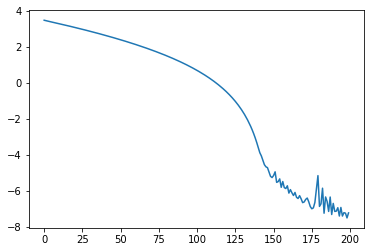

In [ ]:
plt.plot(losses)

In [ ]:
list(k.parameters())

[Parameter containing:
 tensor([[1.3399666548]], requires_grad=True),
 Parameter containing:
 tensor([0.4287088215], requires_grad=True),
 Parameter containing:
 tensor([[0.1471098363]], requires_grad=True),
 Parameter containing:
 tensor([[0.1456232816]], requires_grad=True),
 Parameter containing:
 tensor([-0.4133742750], requires_grad=True),
 Parameter containing:
 tensor([[0.0269221999]], requires_grad=True),
 Parameter containing:
 tensor([0.4979344904], requires_grad=True),
 Parameter containing:
 tensor([[0.1377777308]], requires_grad=True)]

## Other

### Testing

#### Random Testing

The goal is to generate random set of data and parameters and check that `meteo_imp` implementation is the same of `pykalman` implementation

In [ ]:
test_close(
    tst.filter.filter(tst.data, tst.mask_torch),
    tst.filter_pyk.filter(tst.data_pyk)
)

AssertionError: close:
ListNormal(mean=tensor([[-1.2009022236, -1.2801513672,  0.1241119504],
        [-3.8901658058, -2.4111485481, -0.8129007816],
        [-1.6905851364, -0.3650660515, -0.3619496822],
        [-2.5982863903, -1.7156119347, -0.5184043050],
        [-2.4914917946, -1.1824398041, -0.2795265913],
        [-2.7925603390, -1.5949568748, -0.6703749895],
        [-2.6015672684, -1.4078283310, -0.2451970577],
        [-1.5200183392, -0.3549404144, -0.2891225815],
        [-3.2590429783, -2.2824332714, -0.5310008526],
        [-3.6384706497, -2.0416266918, -0.9887318611]]), cov=tensor([[[ 0.3472036123, -0.0683073401,  0.1338070631],
         [-0.0683072805,  0.0863315463,  0.0947744697],
         [ 0.1338073611,  0.0947746634,  0.2892773747]],

        [[ 0.1643971205, -0.0475280285,  0.0211700201],
         [-0.0475286245,  0.0876121521,  0.1135705709],
         [ 0.0211695433,  0.1135703325,  0.2298628092]],

        [[ 0.1573194265, -0.0424685478,  0.0247406960],
         [-0.0424683094,  0.0855915546,  0.1140730977],
         [ 0.0247405767,  0.1140727997,  0.2339072824]],

        [[ 0.1558591127, -0.0425919294,  0.0232368708],
         [-0.0425928831,  0.0857753754,  0.1143169403],
         [ 0.0232368708,  0.1143174767,  0.2330735326]],

        [[ 0.1558748484, -0.0425101519,  0.0234071016],
         [-0.0425082445,  0.0857435465,  0.1143236160],
         [ 0.0234082937,  0.1143231988,  0.2332308888]],

        [[ 0.1558543444, -0.0425169468,  0.0233772993],
         [-0.0425186157,  0.0857468843,  0.1143287420],
         [ 0.0233768225,  0.1143294573,  0.2332190275]],

        [[ 0.1558558941, -0.0425149202,  0.0233823061],
         [-0.0425155163,  0.0857477188,  0.1143304706],
         [ 0.0233811140,  0.1143296361,  0.2332245708]],

        [[ 0.1558552980, -0.0425153971,  0.0233815908],
         [-0.0425143242,  0.0857490301,  0.1143317819],
         [ 0.0233824253,  0.1143317819,  0.2332261801]],

        [[ 0.1558542252, -0.0425165892,  0.0233813524],
         [-0.0425162315,  0.0857474804,  0.1143308878],
         [ 0.0233820677,  0.1143313050,  0.2332265973]],

        [[ 0.1558538675, -0.0425165892,  0.0233809948],
         [-0.0425153971,  0.0857479572,  0.1143310666],
         [ 0.0233814716,  0.1143307686,  0.2332261205]]]))
(array([[  0.71042877,   0.94641107,   0.78902978],
       [  1.92803618,   2.45976525,   2.26926376],
       [  4.95374677,   5.10817505,   5.17529063],
       [ 11.15915605,  10.7910412 ,  10.78739933],
       [ 23.98251596,  22.33508026,  22.16940575],
       [ 50.21677144,  45.98334589,  45.32922037],
       [103.86775898,  94.30006309,  92.61654208],
       [ -1.32682885,  -0.40268798,  -0.24463774],
       [ -1.49955841,  -0.6424668 ,  -0.29658616],
       [ -1.89124012,  -0.93300401,  -0.58007377]]), array([[[ 1.04860151e+00,  3.69115502e-01,  7.14780211e-01],
        [ 3.69115502e-01,  6.06538773e-01,  2.58653879e-01],
        [ 7.14780211e-01,  2.58653879e-01,  9.36298490e-01]],

       [[ 4.34874941e+00,  3.89442119e+00,  3.11272000e+00],
        [ 3.89442119e+00,  3.91523869e+00,  3.09176558e+00],
        [ 3.11272000e+00,  3.09176558e+00,  2.69882315e+00]],

       [[ 1.92429042e+01,  1.67171331e+01,  1.57188915e+01],
        [ 1.67171331e+01,  1.48278915e+01,  1.38883898e+01],
        [ 1.57188915e+01,  1.38883898e+01,  1.33839370e+01]],

       [[ 7.83232702e+01,  7.02158902e+01,  6.71286132e+01],
        [ 7.02158902e+01,  6.32616225e+01,  6.04584350e+01],
        [ 6.71286132e+01,  6.04584350e+01,  5.81248184e+01]],

       [[ 3.25157197e+02,  2.91908722e+02,  2.83768512e+02],
        [ 2.91908722e+02,  2.62368655e+02,  2.55028962e+02],
        [ 2.83768512e+02,  2.55028962e+02,  2.48266140e+02]],

       [[ 1.35248117e+03,  1.21714711e+03,  1.18769936e+03],
        [ 1.21714711e+03,  1.09566566e+03,  1.06913710e+03],
        [ 1.18769936e+03,  1.06913710e+03,  1.04362553e+03]],

       [[ 5.64132784e+03,  5.07873007e+03,  4.96416141e+03],
        [ 5.07873007e+03,  4.57254956e+03,  4.46938003e+03],
        [ 4.96416141e+03,  4.46938003e+03,  4.36891734e+03]],

       [[ 1.81025162e-01, -3.21083720e-02,  6.28513364e-02],
        [-3.21083768e-02,  1.04132003e-01,  1.58419690e-01],
        [ 6.28514668e-02,  1.58419811e-01,  3.49900711e-01]],

       [[ 2.00838375e+00,  1.70018234e+00,  1.24325485e+00],
        [ 1.70018242e+00,  1.72931460e+00,  1.27189983e+00],
        [ 1.24325501e+00,  1.27189992e+00,  1.17847363e+00]],

       [[ 9.28740350e+00,  7.97332777e+00,  7.14770899e+00],
        [ 7.97332779e+00,  7.13895483e+00,  6.37338543e+00],
        [ 7.14770919e+00,  6.37338559e+00,  5.99379479e+00]]]))

In [ ]:
n_dim_state = 3 
n_dim_obs = 3
n_obs = 10
p_missing = .3

In [ ]:
to_posdef = PosDef().transform

In [ ]:
data = torch.rand(n_obs, n_dim_obs)
mask = torch.rand(n_obs, n_dim_obs) > p_missing
mask_torch = mask.all(1)

In [ ]:
mask[:10]

tensor([[ True, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [False,  True,  True],
        [ True, False, False],
        [ True, False,  True],
        [ True,  True,  True],
        [ True,  True, False]])

In [ ]:
mask_torch[:10]

tensor([False,  True,  True,  True,  True, False, False, False,  True, False])

In [ ]:
params = {
    'transition_matrices': torch.rand(n_dim_state, n_dim_state),
    'transition_offsets':  torch.rand(n_dim_state),        
    'transition_cov':      to_posdef(torch.rand(n_dim_state, n_dim_state)),        
    'obs_matrices':        torch.rand(n_dim_obs, n_dim_state),
    'obs_offsets':         torch.rand(n_dim_obs),          
    'obs_cov':             to_posdef(torch.rand(n_dim_obs, n_dim_obs)),            
    'initial_state_mean':  torch.rand(n_dim_state),        
    'initial_state_cov':   to_posdef(torch.rand(n_dim_state, n_dim_state)),
}

In [ ]:
params2pyk = {
    'transition_matrices': 'transition_matrices',
    'transition_offsets':  'transition_offsets',        
    'transition_cov':      'transition_covariance',        
    'obs_matrices':        'observation_matrices',
    'obs_offsets':         'observation_offsets',          
    'obs_cov':             'observation_covariance',            
    'initial_state_mean':  'initial_state_mean',        
    'initial_state_cov':   'initial_state_covariance',
}

In [ ]:
params

{'transition_matrices': tensor([[0.5314818621, 0.1587299109, 0.6541759968],
         [0.3278088570, 0.6532081366, 0.3958292603],
         [0.9146959186, 0.2036490440, 0.2018010020]]),
 'transition_offsets': tensor([0.2017830014, 0.9497213960, 0.6666255593]),
 'transition_cov': tensor([[0.9702556729, 0.1239150539, 0.7471799254],
         [0.1239150539, 0.5321590304, 0.3935724497],
         [0.7471799254, 0.3935724497, 1.3576247692]]),
 'obs_matrices': tensor([[0.1591441035, 0.7652890682, 0.2978977561],
         [0.8034619093, 0.3813496828, 0.7860229611],
         [0.1115159988, 0.2476751208, 0.6524382234]]),
 'obs_offsets': tensor([0.6057037711, 0.3725206256, 0.7980347276]),
 'obs_cov': tensor([[0.7786419988, 0.9252295494, 0.1886124313],
         [0.9252295494, 1.1313515902, 0.2879850864],
         [0.1886124313, 0.2879850864, 0.4364176095]]),
 'initial_state_mean': tensor([0.4340034127, 0.1370570064, 0.5117283463]),
 'initial_state_cov': tensor([[0.0813313425, 0.2482795715, 0.151336327

In [ ]:
k = KalmanFilter(**params)

In [ ]:
pred = k.smooth(data, mask_torch)

make a `pykalman` model using the same parameters

In [ ]:
data_pyk = np.ma.masked_array(data.numpy(), mask = mask.numpy())

In [ ]:
pyk_k = pykalman.standard.KalmanFilter(

    transition_matrices=k.transition_matrices.detach().numpy(),
    transition_offsets=k.transition_offsets.detach().numpy(),
    transition_covariance=k.transition_cov.detach().numpy(),
    observation_matrices=k.obs_matrices.detach().numpy(),
    observation_offsets=k.obs_offsets.detach().numpy(),
    observation_covariance=k.obs_cov.detach().numpy(),
    initial_state_mean=k.initial_state_mean.detach().numpy(),
    initial_state_covariance=k.initial_state_cov.detach().numpy()
)

In [ ]:
pred_pyk = pyk_k.smooth(data_pyk)

In [ ]:
for p in params.keys():
    print(p, getattr(k, p))

transition_matrices Parameter containing:
tensor([[0.5314818621, 0.1587299109, 0.6541759968],
        [0.3278088570, 0.6532081366, 0.3958292603],
        [0.9146959186, 0.2036490440, 0.2018010020]], requires_grad=True)
transition_offsets Parameter containing:
tensor([0.2017830014, 0.9497213960, 0.6666255593], requires_grad=True)
transition_cov tensor([[0.9702557921, 0.1239150614, 0.7471799850],
        [0.1239150614, 0.5321591496, 0.3935724497],
        [0.7471799850, 0.3935724497, 1.3576248884]], grad_fn=<AddBackward0>)
obs_matrices Parameter containing:
tensor([[0.1591441035, 0.7652890682, 0.2978977561],
        [0.8034619093, 0.3813496828, 0.7860229611],
        [0.1115159988, 0.2476751208, 0.6524382234]], requires_grad=True)
obs_offsets Parameter containing:
tensor([0.6057037711, 0.3725206256, 0.7980347276], requires_grad=True)
obs_cov tensor([[0.7786421180, 0.9252294898, 0.1886124313],
        [0.9252294898, 1.1313517094, 0.2879850864],
        [0.1886124313, 0.2879850864, 0.43641

In [ ]:
for p in params.keys():
    print(p, getattr(pyk_k, params2pyk[p]))

transition_matrices [[0.53148186 0.15872991 0.654176  ]
 [0.32780886 0.65320814 0.39582926]
 [0.9146959  0.20364904 0.201801  ]]
transition_offsets [0.201783   0.9497214  0.66662556]
transition_cov [[0.9702558  0.12391506 0.74718   ]
 [0.12391506 0.53215915 0.39357245]
 [0.74718    0.39357245 1.3576249 ]]
obs_matrices [[0.1591441  0.76528907 0.29789776]
 [0.8034619  0.38134968 0.78602296]
 [0.111516   0.24767512 0.6524382 ]]
obs_offsets [0.6057038  0.37252063 0.7980347 ]
obs_cov [[0.7786421  0.9252295  0.18861243]
 [0.9252295  1.1313517  0.2879851 ]
 [0.18861243 0.2879851  0.4364177 ]]
initial_state_mean [0.4340034  0.137057   0.51172835]
initial_state_cov [[0.08133144 0.24827957 0.15133633]
 [0.24827957 1.036492   0.18954173]
 [0.15133633 0.18954173 0.78230935]]


In [ ]:
tst = KalmanFilterTester()

In [ ]:
test_close(pred, pred_pyk)

AssertionError: close:
ListNormal(mean=tensor([[ 0.1430051625, -0.7834703326, -0.1193112731],
        [-0.5063856244, -0.1570073366, -0.3752012849],
        [ 0.4810954332, -0.7205970287,  0.2110576034],
        [ 0.9152259827, -0.7125056982,  0.3896418214],
        [-0.0477739573,  0.1948724091,  0.0489260852],
        [-0.7181638479,  0.5749417543, -0.5476398468],
        [-0.9425613880,  0.3971621990, -0.8002147675],
        [-0.7286841869,  0.1088507175, -0.4608097076],
        [ 0.5366930962, -0.2165226936,  0.1538271904],
        [ 0.5532870293,  1.0451090336,  1.1444844007]], grad_fn=<CopySlices>), cov=tensor([[[ 0.0458634533,  0.1323727220,  0.0791139752],
         [ 0.1323727369,  0.6356528997, -0.0156198442],
         [ 0.0791139677, -0.0156198740,  0.5917835832]],

        [[ 0.2313160598,  0.1742176116, -0.0811998770],
         [ 0.1742181629,  0.2739555836,  0.0895741582],
         [-0.0811987445,  0.0895739868,  0.3135890961]],

        [[ 0.2024308741,  0.1442574561, -0.0768100619],
         [ 0.1442573965,  0.2445938587,  0.0984742865],
         [-0.0768094882,  0.0984741449,  0.3216813803]],

        [[ 0.2042530775,  0.1464323103, -0.0763803720],
         [ 0.1464323997,  0.2488655150,  0.1018891409],
         [-0.0763802230,  0.1018890366,  0.3267323375]],

        [[ 0.2212889194,  0.1700689048, -0.0680535287],
         [ 0.1700690687,  0.2866749167,  0.1200854778],
         [-0.0680539608,  0.1200850904,  0.3402861357]],

        [[ 0.6585845947,  0.0601328909,  0.2948330641],
         [ 0.0601328909,  0.6690787077,  0.2529650629],
         [ 0.2948336005,  0.2529654503,  0.8740483522]],

        [[ 0.8133347034,  0.1875652075,  0.3540329933],
         [ 0.1875623465,  0.8686182499,  0.2423343658],
         [ 0.3540306091,  0.2423349619,  0.8958110809]],

        [[ 0.7408380508,  0.2029280663,  0.3333144188],
         [ 0.2029232979,  0.8584184647,  0.2791090012],
         [ 0.3333191872,  0.2791180611,  0.9101500511]],

        [[ 0.3866987228,  0.3702745438, -0.0381088257],
         [ 0.3702421188,  0.5363788605,  0.1696672440],
         [-0.0381336212,  0.1696758270,  0.3714637756]],

        [[ 1.3231682777,  0.5578712821,  1.0965143442],
         [ 0.5578587055,  1.0971891880,  0.8761948347],
         [ 1.0965268612,  0.8762198687,  1.8563498259]]], grad_fn=<CopySlices>))
(array([[ 0.43400341,  0.13705701,  0.51172835],
       [ 0.78896339,  1.38407536,  1.19478553],
       [ 1.62239691,  2.58537095,  1.91126169],
       [ 2.72473476,  3.92687611,  3.06282824],
       [ 4.27687151,  5.62033804,  4.57671569],
       [ 6.36095594,  7.83456629,  6.64682476],
       [ 9.17428893, 10.78350927,  9.42180383],
       [12.95293454, 14.7304362 , 13.15569101],
       [18.03033087, 20.02525628, 18.1692928 ],
       [24.8490992 , 27.13282162, 24.90360141]]), array([[[8.13314393e-02, 2.48279572e-01, 1.51336327e-01],
        [2.48279572e-01, 1.03649199e+00, 1.89541727e-01],
        [1.51336327e-01, 1.89541727e-01, 7.82309353e-01]],

       [[1.54061847e+00, 7.04431938e-01, 1.12452860e+00],
        [7.04431938e-01, 1.34933910e+00, 8.88315771e-01],
        [1.12452860e+00, 8.88315771e-01, 1.66446306e+00]],

       [[3.23702993e+00, 2.15756736e+00, 2.87830697e+00],
        [2.15756736e+00, 2.58710820e+00, 2.30613048e+00],
        [2.87830697e+00, 2.30613048e+00, 3.52095414e+00]],

       [[6.30102434e+00, 5.08225077e+00, 5.82817274e+00],
        [5.08225077e+00, 5.39902837e+00, 5.14515716e+00],
        [5.82817274e+00, 5.14515716e+00, 6.37257913e+00]],

       [[1.15920018e+01, 1.04582601e+01, 1.10769157e+01],
        [1.04582601e+01, 1.08610170e+01, 1.04746961e+01],
        [1.10769157e+01, 1.04746961e+01, 1.15808361e+01]],

       [[2.11166961e+01, 2.02831548e+01, 2.04600071e+01],
        [2.02831548e+01, 2.09965549e+01, 2.01545072e+01],
        [2.04600071e+01, 2.01545072e+01, 2.08248545e+01]],

       [[3.82110988e+01, 3.80398790e+01, 3.73488073e+01],
        [3.80398790e+01, 3.94412582e+01, 3.76975125e+01],
        [3.73488073e+01, 3.76975125e+01, 3.75105701e+01]],

       [[6.90282234e+01, 7.01129921e+01, 6.77743502e+01],
        [7.01129921e+01, 7.28215936e+01, 6.93631248e+01],
        [6.77743502e+01, 6.93631248e+01, 6.75495223e+01]],

       [[1.24573828e+02, 1.27971142e+02, 1.22630548e+02],
        [1.27971142e+02, 1.33088569e+02, 1.26503160e+02],
        [1.22630548e+02, 1.26503160e+02, 1.21724872e+02]],

       [[2.24740234e+02, 2.32333413e+02, 2.21547034e+02],
        [2.32333413e+02, 2.41822466e+02, 2.29563154e+02],
        [2.21547034e+02, 2.29563154e+02, 2.19407035e+02]]]))

### Compare Statsmodels

In [ ]:
import statsmodels.api as sm
import statsmodels

In [ ]:
sm_kf = statsmodels.tsa.statespace.kalman_filter.KalmanFilter(
    k_endog = 3,
    k_states = 3,
    initialization = 'known',
    initial_state = pyk_ncov.initial_state_mean,
    initial_state_cov = pyk_ncov.initial_state_covariance,
    design = pyk_ncov.observation_matrices,
    obs_cov = pyk_ncov.observation_covariance,
    transition = pyk_ncov.transition_matrices,
    state_cov = pyk_ncov.transition_covariance)

In [ ]:
sm_kf.bind(X_ncov.detach().numpy())

In [ ]:
sm_pred = sm_kf.filter() 

In [ ]:
sm_pred.predicted_state.shape

(3, 11)

In [ ]:
sm_pred.predicted_state_cov.shape

(3, 3, 11)

In [ ]:
mean = MultivariateNormal(torch.tensor(sm_pred.predicted_state[:, 0]), torch.tensor(sm_pred.predicted_state_cov[:, :, 0]))

In [ ]:
sm_kf.loglikeobs()

array([-5.39001684e+00, -1.64627102e+01, -2.78811272e+03, -3.23951658e+03,
       -3.54026676e+04, -6.07624446e+03, -7.80461446e+02, -2.63887063e+02,
       -3.70947972e+02, -5.16146147e+02])

## Export

In [ ]:
#| hide
from nbdev import nbdev_export
nbdev_export()